In [67]:
# Import dependencies
import numpy as np #numpy for matrix math and generating toy data
import matplotlib.pyplot as plt # for visualization and plots
from skimage.io import imread, imsave # to save the images
import os

%matplotlib inline 

In [68]:
# a few hyperparameters
dim = 3 # color data is 3 dimensional (red, green, blue)
network_dim = (32, 32)
# let's let it run for WAYYYYYY too long cause I have nothing better to do than stare at a bunch of noisy images!
iterations = 500 # training is iterative. How many iterations do we run for?
init_learning_rate = 0.1 # how fast should the model learn?


seed = 13 # the seed for the PRNG (so results can be reproduced)
num_data_points = 100000 # the number of data points to generate
data_type = 'RANDOM'

decay_radius = True
decay_lr = True

image_save_folder = 'images_random_true_true'
weight_save_file = 'weights_random_true_true'

if(not os.path.exists(image_save_folder)):
    os.mkdir(image_save_folder)

normalise_data = True # should make all data 0..1
normalise_columns = True # True if features are on diffent scales and normalization should only occur between each feature


In [69]:
if(data_type == 'RANDOM'):
    # seed the PRNG
    np.random.seed(seed) 
    # Generate random color data (red, green, blue as columns, each row is a new color)
    raw_data = np.random.randint(0, 255, (num_data_points, dim))
# this is the center row of the table found here: http://www.rapidtables.com/web/color/RGB_Color.htm
elif(data_type == 'COLOR_WHEEL'):
    raw_data = np.array([
        [255, 0, 0],
        [255, 128, 0],
        [255, 255, 0],
        [128, 255, 0],
        [0  , 255, 0],
        [0  , 255, 128],
        [0  , 255, 255],
        [0  ,   0, 255],
        [127,   0, 255],
        [255,   0, 255],
        [255,   0, 127]
    ], dtype=float)
elif(data_type == 'RGB'):
    raw_data = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]], dtype=float)
# Show first 10 values of data to ensure it looks good
print(raw_data[:10, :]) # Transpose the matrix so each row is a color (rather than each column). 

[[ 82 176  74]
 [ 16 230  98]
 [244 153 236]
 [186 227 154]
 [244 126 194]
 [174 182 229]
 [205  74  73]
 [ 75  52   2]
 [160 147 149]
 [147 139 214]]


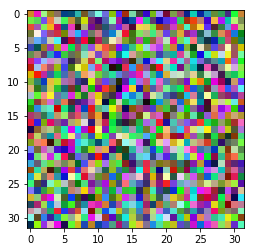

In [70]:
# Define our model

# create a weight matrix with a `dim` dimensional vector for each neuron
net = np.random.random((network_dim[0], network_dim[1], dim))

# Let take a look at the weights at the very beginning. Its just a bunch of random colors
plt.imshow(net)

In [71]:
# initial neighbourhood radius
init_radius = max(network_dim[0], network_dim[1]) / 2
# radius decay parameter
time_const = iterations / np.log(init_radius)

In [72]:
# Normalise the data
data = raw_data  # don't mess around with the raw data. Instead, make a copy!
if(normalise_data):
    if(normalise_columns):
        # find the max value for each column. In this case, we know it should be ~255, but other data may be different
        col_maxes = raw_data.max(axis=0) 
        # normalise along each column
        data = raw_data / col_maxes
    else:
        # normalise the entire dataset. 
        data = raw_data / raw_data.max()

In [73]:
# we need a function to find the best-matching unit
def find_bmu(sample, net, dim):
    bmu_idx = (0, 0) # start with the best matching unit being the (0,0) one
    min_dist = np.iinfo(np.int).max # start with a very high min_dist. It will be set correctly on the first iteration
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            # for each neuron
            w = net[x,y, :] # get the neuron weight values
            sqr_dist = np.sum((w-sample)**2) # get the distance between the weights and the sample
            if(sqr_dist < min_dist):
                # if this is a better distance than any of the previous ones, record it as min_dist and bmu_idx
                min_dist = sqr_dist
                bmu_idx = (x,y)
    bmu = net[bmu_idx[0], bmu_idx[1], :] # get the weights for the closest neuron
    return (bmu, bmu_idx)

In [74]:
# functions to decay learning rate and radius over time

def decay_radius_func(radius, i, time_const):
    return radius * np.exp(-i / time_const)

def decay_lr_func(lr, i, iterations):
    return lr * np.exp(-i / iterations)

# Calculate Influence

$$ \exp {\frac{-d}{2*r^2}} $$

In [75]:
# calculate the influence given the distance the the radius
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

def update_weights(lr, r, net, bmu_idx, sample):
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            # for each neuron
            w = net[x,y, :] # get the neuron weight values
            # calculate the square distance in the network between this neuron and the bmu neuron
            sqr_dist = np.sum((np.array([x,y]) - bmu_idx)**2)
            # if this neuron is in the radius
            if(sqr_dist <= r**2):
                influence = calculate_influence(sqr_dist, r)
                new_w = w + (lr * influence * (sample - w))
                net[x, y, :] = new_w
                  
    return net

C:\Users\amit-personal\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


After 99 iterations: 


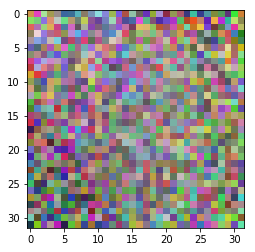

After 199 iterations: 


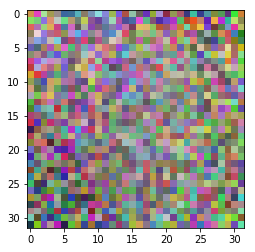

After 299 iterations: 


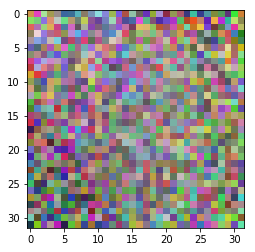

C:\Users\amit-personal\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\amit-personal\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


After 399 iterations: 


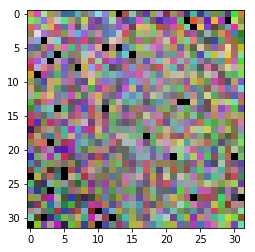

After 499 iterations: 


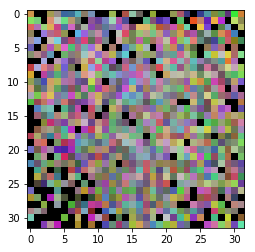

In [76]:
# THE ACTUAL LEARNING PROCESS!!!! YAY!! FINALLY!!!!!

    
radius = init_radius
lr = init_learning_rate

#nets = np.zeros(shape=(network_dim[0] * network_dim[1], 3, iterations))


for i in range(iterations):
    # select the i-th training sample (modulo # of samples)
    sample = data[i % data.shape[0]]
    # find the best matching unit
    bmu, bmu_idx = find_bmu(sample, net, dim)
    
    net = update_weights(lr, radius, net, bmu_idx, sample)
    
    if(decay_radius):
        radius = decay_radius_func(radius, i, time_const)
    if(decay_lr):
        lr = decay_lr_func(lr, i, iterations)

    
    if((i+1) % 100 == 0):
        print("After " + str(i) + " iterations: ")
        plt.imshow(net)
        plt.show()
        
    imsave(image_save_folder + '/' + str(i) + '.png', net)

In [77]:
# Lets save the weights as a binary file, just in case we want to load them later
np.save(weight_save_file, net)